In [136]:
# Data Preprocessing
import pandas as pd
import pickle

# Load the CSV file into a DataFrame
scoring_data = pd.read_csv('deliveries.csv')
matches_data=pd.read_csv('matches.csv')

#renaming the id column inorder to perform merge operation
matches_data=matches_data.rename(columns={'id':'match_id'})

matches_data.head()

,match_id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


In [137]:
#merging two datasets
cricket_data = pd.merge(scoring_data, matches_data, on='match_id', how='left')

In [138]:
# Convert 'over' and 'ball' to a single count for easier calculation
cricket_data['ball_count'] = cricket_data['over'] * 6 + cricket_data['ball']

# Sorting the data to ensure the rolling operation respects the match and inning progression
cricket_data.sort_values(by=['match_id', 'inning', 'ball_count'], inplace=True)

# Reset the index to ensure proper rolling calculations
cricket_data.reset_index(drop=True, inplace=True)

# Calculate rolling totals for both runs and wickets, using the last 30 balls
cricket_data['score_last_30_balls'] = cricket_data.groupby(['match_id', 'inning'])['total_runs'].transform(
    lambda x: x.rolling(window=30, min_periods=1).sum())

cricket_data['wickets_last_30_balls'] = cricket_data.groupby(['match_id', 'inning'])['is_wicket'].transform(
    lambda x: x.rolling(window=30, min_periods=1).sum())

# Calculate the cumulative score
cricket_data['cumulative_score'] = cricket_data.groupby(['match_id', 'inning'])['total_runs'].cumsum()

# Adjust the first 5 overs to just cumulative sum up to that ball
mask = cricket_data['over'] < 5
cricket_data.loc[mask, 'score_last_30_balls'] = cricket_data.loc[mask].groupby(['match_id', 'inning'])['total_runs'].cumsum()
cricket_data.loc[mask, 'wickets_last_30_balls'] = cricket_data.loc[mask].groupby(['match_id', 'inning'])['is_wicket'].cumsum()



In [139]:
# Calculate the cumulative total score for each ball in the innings
cricket_data['cumulative_score'] = cricket_data.groupby(['match_id', 'inning'])['total_runs'].cumsum()

# Calculate the final total score for each innings and merge this as 'total_score' for each delivery
final_scores = cricket_data.groupby(['match_id', 'inning'])['cumulative_score'].max().reset_index()
final_scores.rename(columns={'cumulative_score': 'total_score'}, inplace=True)
cricket_data = pd.merge(cricket_data, final_scores, on=['match_id', 'inning'], how='left')


In [140]:
cricket_data.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batter', 'bowler', 'non_striker', 'batsman_runs', 'extra_runs',
       'total_runs', 'extras_type', 'is_wicket', 'player_dismissed',
       'dismissal_kind', 'fielder', 'season', 'city', 'date', 'match_type',
       'player_of_match', 'venue', 'team1', 'team2', 'toss_winner',
       'toss_decision', 'winner', 'result', 'result_margin', 'target_runs',
       'target_overs', 'super_over', 'method', 'umpire1', 'umpire2',
       'ball_count', 'score_last_30_balls', 'wickets_last_30_balls',
       'cumulative_score', 'total_score'],
      dtype='object')

In [141]:
#Removing Unwanted Columns from the dataframe
columns= ['fielder','dismissal_kind','player_dismissed','is_wicket','non_striker','extras_type','bowler','batter','match_id','batsman_runs', 'extra_runs',
'extras_type','is_wicket', 'player_dismissed','dismissal_kind', 'fielder', 'season','toss_winner','result','super_over', 'method', 'umpire1', 'umpire2',
'target_overs','venue','player_of_match','team1', 'team2','result_margin', 'target_runs','total_runs','match_type','ball_count']
cricket_data.drop(columns=columns, axis=1, inplace=True)

In [142]:
cricket_data.shape

(260920, 13)

In [143]:
cricket_data.columns

Index(['inning', 'batting_team', 'bowling_team', 'over', 'ball', 'city',
       'date', 'toss_decision', 'winner', 'score_last_30_balls',
       'wickets_last_30_balls', 'cumulative_score', 'total_score'],
      dtype='object')

In [144]:
cricket_data.isnull().sum()

inning                       0
batting_team                 0
bowling_team                 0
over                         0
ball                         0
city                     12397
date                         0
toss_decision                0
winner                     490
score_last_30_balls          0
wickets_last_30_balls        0
cumulative_score             0
total_score                  0
dtype: int64

In [145]:
cricket_data.dropna(inplace=True)

In [146]:
cricket_data['batting_team'].unique()

array(['Kolkata Knight Riders', 'Royal Challengers Bangalore',
       'Chennai Super Kings', 'Kings XI Punjab', 'Rajasthan Royals',
       'Delhi Daredevils', 'Mumbai Indians', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Rising Pune Supergiants', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Delhi Capitals', 'Punjab Kings',
       'Lucknow Super Giants', 'Gujarat Titans',
       'Royal Challengers Bengaluru'], dtype=object)

In [147]:
# Punjab Kings is the new name of Kings XI Punjab & Delhi Capitals is the new name of Delhi Daredevils

cricket_data['batting_team'] = cricket_data['batting_team'].replace({
    'Kings XI Punjab': 'Punjab Kings',
    'Delhi Daredevils': 'Delhi Capitals'
})

In [148]:
# Updating in the bowling team column

cricket_data['bowling_team'] = cricket_data['bowling_team'].replace({
    'Kings XI Punjab': 'Punjab Kings',
    'Delhi Daredevils': 'Delhi Capitals'
})


In [149]:
# Updating the winner column
cricket_data['winner'] = cricket_data['bowling_team'].replace({
    'Kings XI Punjab': 'Punjab Kings',
    'Delhi Daredevils': 'Delhi Capitals'
})

In [150]:
# Keeping only consistent teams
consistent_teams = ['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
                    'Mumbai Indians', 'Punjab Kings', 'Royal Challengers Bangalore',
                    'Delhi Capitals', 'Sunrisers Hyderabad','Gujarat Titans','Lucknow Super Giants']

In [151]:
cricket_data['city'].unique()

array(['Bangalore', 'Chandigarh', 'Delhi', 'Mumbai', 'Kolkata', 'Jaipur',
       'Hyderabad', 'Chennai', 'Cape Town', 'Port Elizabeth', 'Durban',
       'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Kochi', 'Indore', 'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi',
       'Abu Dhabi', 'Rajkot', 'Kanpur', 'Bengaluru', 'Sharjah', 'Dubai',
       'Navi Mumbai', 'Lucknow', 'Guwahati', 'Mohali'], dtype=object)

In [152]:
consistent_cities= ['Bangalore', 'Chandigarh', 'Delhi', 'Mumbai', 'Kolkata', 'Jaipur',
       'Hyderabad', 'Chennai',  'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Kochi', 'Indore', 'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi',
        'Rajkot', 'Kanpur', 'Bengaluru', 
       'Navi Mumbai', 'Lucknow', 'Guwahati', 'Mohali']

In [153]:
cricket_data = cricket_data[(cricket_data['batting_team'].isin(consistent_teams)) & (cricket_data['bowling_team'].isin(consistent_teams)) &
(cricket_data['winner'].isin(consistent_teams)) & (cricket_data['city'].isin(consistent_cities))]

In [154]:
# Converting the column 'date' from string into datetime object
from datetime import datetime
cricket_data['date'] = cricket_data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [155]:
# Feature Engineering
ipl_data=pd.get_dummies(cricket_data, columns=['batting_team','bowling_team','winner','toss_decision','city'],dtype=int)

In [158]:
# Rearranging the columns accordingly
ipl_data = ipl_data[['inning','date', 'batting_team_Chennai Super Kings', 'batting_team_Delhi Capitals',
       'batting_team_Gujarat Titans', 'batting_team_Kolkata Knight Riders',
       'batting_team_Lucknow Super Giants', 'batting_team_Mumbai Indians',
       'batting_team_Punjab Kings', 'batting_team_Rajasthan Royals',
       'batting_team_Royal Challengers Bangalore',
       'batting_team_Sunrisers Hyderabad', 'bowling_team_Chennai Super Kings',
       'bowling_team_Delhi Capitals', 'bowling_team_Gujarat Titans',
       'bowling_team_Kolkata Knight Riders',
       'bowling_team_Lucknow Super Giants', 'bowling_team_Mumbai Indians',
       'bowling_team_Punjab Kings', 'bowling_team_Rajasthan Royals',
       'bowling_team_Royal Challengers Bangalore',
       'bowling_team_Sunrisers Hyderabad', 'winner_Chennai Super Kings',
       'winner_Delhi Capitals', 'winner_Gujarat Titans',
       'winner_Kolkata Knight Riders', 'winner_Lucknow Super Giants',
       'winner_Mumbai Indians', 'winner_Punjab Kings',
       'winner_Rajasthan Royals', 'winner_Royal Challengers Bangalore',
       'winner_Sunrisers Hyderabad', 'toss_decision_bat',
       'toss_decision_field', 'city_Ahmedabad', 'city_Bangalore',
       'city_Bengaluru', 'city_Chandigarh', 'city_Chennai', 'city_Cuttack',
       'city_Delhi', 'city_Dharamsala', 'city_Guwahati', 'city_Hyderabad',
       'city_Indore', 'city_Jaipur', 'city_Kolkata', 'city_Lucknow',
       'city_Mohali', 'city_Mumbai', 'city_Navi Mumbai', 'city_Pune',
       'city_Raipur', 'city_Ranchi', 'city_Visakhapatnam','over', 'ball',  'score_last_30_balls',
       'wickets_last_30_balls', 'cumulative_score', 'total_score',
       ]]

In [185]:
# Splitting the data to train and test
# Splitting the data into train and test set
x_train = ipl_data.drop(labels='total_score', axis=1)[ipl_data['date'].dt.year <= 2022]
x_test = ipl_data.drop(labels='total_score', axis=1)[ipl_data['date'].dt.year > 2022]

In [188]:
y_train = ipl_data[ipl_data['date'].dt.year <= 2022]['total_score'].values
y_test  = ipl_data[ipl_data['date'].dt.year > 2022]['total_score'].values

In [192]:
# Removing the 'date' column
x_train.drop(labels='date', axis=True, inplace=True)
x_test.drop(labels='date', axis=True, inplace=True)

## Linear Regression

In [193]:
# --- Model Building ---
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(x_train,y_train)

LinearRegression()

In [ ]:
predict_linear = linear.predict(x_test)

In [ ]:
linear.score(x_test,y_test)

In [ ]:
import seaborn as sns
sns.distplot(y_test-predict_linear)

In [ ]:
from sklearn import metrics
import numpy as np
print('MAE:', metrics.mean_absolute_error(y_test, predict_linear))
print('MSE:', metrics.mean_squared_error(y_test, predict_linear))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predict_linear)))

## Ridge Regression

In [194]:
## Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [195]:
ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(x_train,y_train)

c:\Users\DYAVADI\Desktop\DataScience\GitHub\MachineLearningProjects\IPL_SCORE_PREDICTION_APPLICATION\venv\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.57257e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\DYAVADI\Desktop\DataScience\GitHub\MachineLearningProjects\IPL_SCORE_PREDICTION_APPLICATION\venv\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.81577e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\DYAVADI\Desktop\DataScience\GitHub\MachineLearningProjects\IPL_SCORE_PREDICTION_APPLICATION\venv\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.32636e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\DYAVADI\Desktop\DataScience\GitHub\MachineLearningProje

GridSearchCV(cv=15, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40]},
             scoring='neg_mean_squared_error')

In [196]:
ridge_regressor.best_params_

{'alpha': 40}

In [197]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 40}
-538.5773521235781


In [198]:
predict=ridge_regressor.predict(x_test)

In [199]:
ridge_regressor.score(x_test,y_test)

-688.1011581031494

C:\Users\DYAVADI\AppData\Local\Temp\ipykernel_21720\1387842392.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-predict)


<Axes: ylabel='Density'>

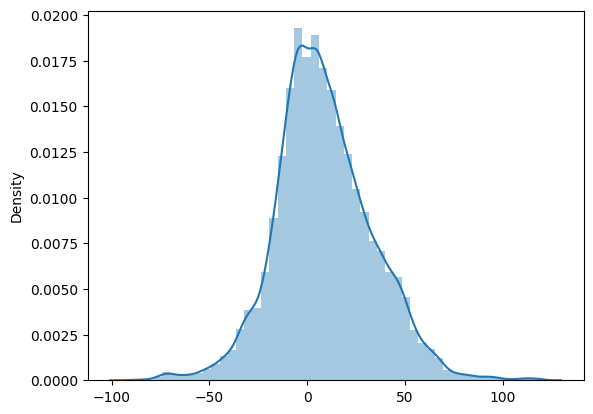

In [200]:
import seaborn as sns
sns.distplot(y_test-predict)

In [201]:
from sklearn import metrics
import numpy as np
print('MAE:', metrics.mean_absolute_error(y_test, predict))
print('MSE:', metrics.mean_squared_error(y_test, predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predict)))

MAE: 19.845637700595475
MSE: 688.1011581031494
RMSE: 26.231682334595877


## Lasso Regression

In [202]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [203]:
lasso=Lasso()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}
lasso_regressor=GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=5)

In [205]:
lasso_regressor.fit(x_train,y_train)


c:\Users\DYAVADI\Desktop\DataScience\GitHub\MachineLearningProjects\IPL_SCORE_PREDICTION_APPLICATION\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.327e+07, tolerance: 1.191e+04
  model = cd_fast.enet_coordinate_descent(


In [ ]:
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

In [ ]:
predict_lasso=lasso_regressor.predict(x_test)

In [ ]:
import seaborn as sns
sns.distplot(y_test-predict_lasso)

In [ ]:
from sklearn import metrics
import numpy as np
print('MAE:', metrics.mean_absolute_error(y_test, predict_lasso))
print('MSE:', metrics.mean_squared_error(y_test, predict_lasso))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predict_lasso)))

## Decision Tree

In [ ]:
from sklearn.